In [1]:
#필요한 라이브러리
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
tf.config.list_physical_devices()
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
#CPU만 작동하게 하는 명령어
tf.config.experimental.set_visible_devices([], 'GPU')


In [2]:
#파일 불러오기
#2017~2019년도
df = pd.read_csv('C:/Users/alscj/python/Data Science/project/data/서울사고건수(2017_2019).csv')
#아래 데이터와 2017년도가 겹치므로 18~19년도만 선택하면
df= df.iloc[365:]

#2015~2017년도
#18~19년도 데이터 형식에 맞게 전처리
df2= pd.read_excel('C:/Users/alscj/python/Data Science/project/data/서울사고건수(2015_2017).xlsx')
df2.drop(['Unnamed: 0','발생시도'],axis=1,inplace=True)
df2.rename({'계':'사고건수'},axis=1,inplace=True)

#날짜를 datatime으로 변환하기 위해선 20XX-XX-XX형식으로 맞출 필요가 있는걸로 보임
#따라서 그에 적절하게 형태를 바꿈
year_lst=[]
month_lst=[]
day_lst=[]
str_date_lst=[]

for i in range(len(df2['발생일'])):
    year_lst.append(str(df2['발생일'][i])[:4])
    month_lst.append(str(df2['발생일'][i])[4:6])
    day_lst.append(str(df2['발생일'][i])[6:])
    str_date_lst.append(year_lst[i]+'-'+month_lst[i]+'-'+day_lst[i]+' '+'00:00:00')
df2['발생일']=str_date_lst


df= pd.concat([df2,df])
df['발생일']=pd.to_datetime(df['발생일'])
print(df.info())
df.sort_values(by='발생일')
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     1826 non-null   datetime64[ns]
 1   사고건수    1826 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.8 KB
None


,발생일,사고건수
0,2015-01-01,62
1,2015-01-02,64
2,2015-01-03,94
3,2015-01-04,86
4,2015-01-05,123
...,...,...
1821,2019-12-27,94
1822,2019-12-28,94
1823,2019-12-29,78
1824,2019-12-30,91


In [3]:
df2= pd.read_excel('C:/Users/alscj/python/Data Science/project/data/서울사고건수(2015_2017).xlsx')
df2.drop(['Unnamed: 0','발생시도'],axis=1,inplace=True)
df2.rename({'계':'사고건수'},axis=1,inplace=True)

#날짜를 datatime으로 변환하기 위해선 20XX-XX-XX형식으로 맞출 필요가 있는걸로 보임
#따라서 그에 적절하게 형태를 바꿈
year_lst=[]
month_lst=[]
day_lst=[]
str_date_lst=[]

for i in range(len(df2['발생일'])):
    year_lst.append(str(df2['발생일'][i])[:4])
    month_lst.append(str(df2['발생일'][i])[4:6])
    day_lst.append(str(df2['발생일'][i])[6:])
    str_date_lst.append(year_lst[i]+'-'+month_lst[i]+'-'+day_lst[i])

df2['사고건수']=str_date_lst
df2

,발생일,사고건수
0,20150101,2015-01-01
1,20150102,2015-01-02
2,20150103,2015-01-03
3,20150104,2015-01-04
4,20150105,2015-01-05
...,...,...
1091,20171227,2017-12-27
1092,20171228,2017-12-28
1093,20171229,2017-12-29
1094,20171230,2017-12-30


In [4]:
df['발생일'] = pd.to_datetime(df['발생일'])
df.set_axis(df['발생일'], inplace=True)
df.head()

,발생일,사고건수
발생일,,
2015-01-01,2015-01-01,62
2015-01-02,2015-01-02,64
2015-01-03,2015-01-03,94
2015-01-04,2015-01-04,86
2015-01-05,2015-01-05,123


In [5]:
df.describe()

,사고건수
count,1826.000000
mean,108.642935
std,20.312264
min,38.000000
25%,96.000000
50%,110.000000
75%,122.000000
max,193.000000


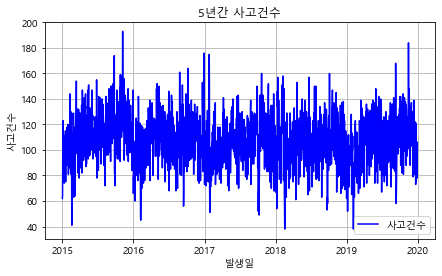

In [6]:
# 분포확인
plt.figure(figsize=(7, 4))

plt.title('5년간 사고건수')
plt.xlabel('발생일')
plt.ylabel('사고건수')
plt.grid()

plt.plot(df['발생일'], df['사고건수'], label='사고건수', color='b')
plt.legend(loc='best')

plt.show()

In [7]:
# 사고건수를 정규화

from sklearn.preprocessing import MinMaxScaler

df_accident = df[['사고건수']]
scaler = MinMaxScaler()
df_accident = scaler.fit_transform(df_accident)

# tolist() 함수를 사용하여 같은 위치에 있는 데이터끼리 묶어준다.
accident = df_accident.tolist()
accident

In [10]:
time_steps = 5
x = []
y = []

for i in range(len(accident) - time_steps):
    x.append([accident[i+j] for j in range(time_steps)])
    y.append(accident[time_steps + i])

In [11]:
len(x)

1821

In [12]:
len(y)

1821

In [13]:
x[0]

[[0.1548387096774194],
 [0.16774193548387098],
 [0.3612903225806452],
 [0.3096774193548387],
 [0.5483870967741936]]

In [14]:
y[0]

[0.335483870967742]

In [15]:
x = np.array(x)
y = np.array(y)

In [16]:
x[0]

array([[0.15483871],
       [0.16774194],
       [0.36129032],
       [0.30967742],
       [0.5483871 ]])

In [17]:
y[0]

array([0.33548387])

In [18]:
# train = 1600개, test = 나머지

train_test_split = 1600

X_train = x[:train_test_split, :]
y_train = y[:train_test_split]

X_test = x[train_test_split:,:]
y_test = y[train_test_split:]

In [19]:
X_train.shape

(1600, 5, 1)

In [20]:
X_test.shape

(221, 5, 1)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:


model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(None, 1)),  
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


7/7 [==============================] - 0s 1ms/step


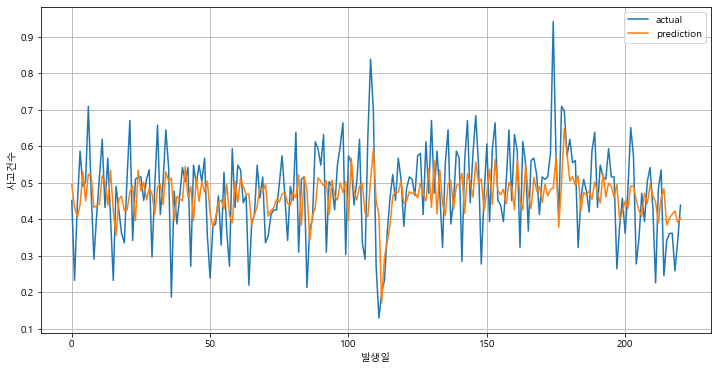

In [26]:
pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.xlabel('발생일')
plt.ylabel('사고건수')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()